In [1]:
!ls /dataset/jta/images_jpg

test  train  val


In [2]:
import sys
import os

import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt



In [3]:
image_path = pathlib.Path("/dataset/jta/images_jpg")
ANNO_PATH = tf.constant("/dataset/jta/new_image_annotations")

image_ds = tf.data.Dataset.list_files(str(image_path/'train/*/*')).shuffle(10000)

for f in image_ds.take(5):
    print(f.numpy())


b'/dataset/jta/images_jpg/train/seq_137/415.jpg'
b'/dataset/jta/images_jpg/train/seq_221/501.jpg'
b'/dataset/jta/images_jpg/train/seq_129/618.jpg'
b'/dataset/jta/images_jpg/train/seq_219/474.jpg'
b'/dataset/jta/images_jpg/train/seq_11/309.jpg'


In [4]:
def to_cam_space(joint):
    cam_transform = tf.constant([[1158,0,960],[0,1158,540],[0,0,1]], dtype=tf.float32)
    joint_homog = tf.linalg.matvec(cam_transform, joint)
    cam_space_joint = joint_homog / joint_homog[2]
    return cam_space_joint

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(len(image_batch)):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        poses = label_batch[n]
        for pose in poses:
            for joint in pose:
                text = f"[{joint[0]},{joint[1]}]"
                print(text)
                cam_space_joint = to_cam_space(joint)
                plt.text(cam_space_joint[0],cam_space_joint[1], text)
        plt.axis('off')

def get_annotation_path(img_path):
    # convert the path to a list of path components
    parts = tf.strings.split(img_path, os.path.sep)
    data_split = parts[-3]
    seq = parts[-2]
    img_name = parts[-1]

    anno_name = tf.strings.split(img_name, '.')[0] + '.npy'
    anno_path = tf.strings.join([ANNO_PATH,data_split,seq,anno_name], separator='/')
    # The second to last is the class-directory
    return anno_path

def get_annotation(anno_path):
    poses = np.load(anno_path, allow_pickle=True)
    annos = np.empty([len(poses),15,3], dtype=np.float32)
    for i, pose in enumerate(poses):
        annos[i,0,0] = pose[0].x3d #TODO ortne richtige gliedmaßen zu
        annos[i,0,1] = pose[0].y3d
        annos[i,0,2] = pose[0].z3d

        annos[i,1,0] = pose[1].x3d
        annos[i,1,1] = pose[1].y3d
        annos[i,1,2] = pose[1].z3d

        annos[i,2,0] = pose[2].x3d
        annos[i,2,1] = pose[2].y3d
        annos[i,2,2] = pose[2].z3d

        annos[i,3,0] = pose[3].x3d
        annos[i,3,1] = pose[3].y3d
        annos[i,3,2] = pose[3].z3d

        annos[i,4,0] = pose[4].x3d
        annos[i,4,1] = pose[4].y3d
        annos[i,4,2] = pose[4].z3d

        annos[i,5,0] = pose[5].x3d
        annos[i,5,1] = pose[5].y3d
        annos[i,5,2] = pose[5].z3d

        annos[i,6,0] = pose[6].x3d
        annos[i,6,1] = pose[6].y3d
        annos[i,6,2] = pose[6].z3d

        annos[i,7,0] = pose[7].x3d
        annos[i,7,1] = pose[7].y3d
        annos[i,7,2] = pose[7].z3d

        annos[i,8,0] = pose[8].x3d
        annos[i,8,1] = pose[8].y3d
        annos[i,8,2] = pose[8].z3d

        annos[i,9,0] = pose[9].x3d
        annos[i,9,1] = pose[9].y3d
        annos[i,9,2] = pose[9].z3d

        annos[i,10,0] = pose[10].x3d
        annos[i,10,1] = pose[10].y3d
        annos[i,10,2] = pose[10].z3d

        annos[i,11,0] = pose[11].x3d
        annos[i,11,1] = pose[11].y3d
        annos[i,11,2] = pose[11].z3d

        annos[i,12,0] = pose[12].x3d
        annos[i,12,1] = pose[12].y3d
        annos[i,12,2] = pose[12].z3d

        annos[i,13,0] = pose[13].x3d
        annos[i,13,1] = pose[13].y3d
        annos[i,13,2] = pose[13].z3d

        annos[i,14,0] = pose[14].x3d
        annos[i,14,1] = pose[14].y3d
        annos[i,14,2] = pose[14].z3d

    return annos

def process_path(file_path):
    anno_path = get_annotation_path(file_path)
    anno = tf.numpy_function(get_annotation, [anno_path], tf.float32)
    anno.set_shape([None,15,3])

    return file_path, anno


In [5]:
import ShAReD_Net.data.load.dataset_jta.joint as joint
import ShAReD_Net.data.load.dataset_jta.pose as pose
sys.modules['joint'] = joint
sys.modules['pose'] = pose

In [6]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = image_ds.map(process_path,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [7]:
def person_pos_from_pose(path, poses):
    poss = tf.reduce_mean(poses, axis=-2)
    return path, poss, poses

In [8]:
pos_pose_ds = labeled_ds.map(person_pos_from_pose)

In [9]:
#@tf.function
def poss_and_poses_to_img(path, poss, poses):
    poss_img = poss_to_img(poss)
    poses_img = poses_to_img(poses)

    return path, poss_img, poses_img

def poss_to_img(poss):
    cam_transform = tf.constant([[1158,0,960],[0,1158,540],[0,0,1]], dtype=tf.float32)
    poss_homog = tf.linalg.matvec(cam_transform, poss)
    poss_img = poss_homog / poss_homog[:,None,-1]
    return tf.concat([poss_img[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_img(poses):
    cam_transform = tf.constant([[1158,0,960],[0,1158,540],[0,0,1]], dtype=tf.float32)
    poses_homog = tf.linalg.matvec(cam_transform, poses)
    poses_img = poses_homog / poses_homog[:,:,None,-1]
    return tf.concat([poses_img[:,:,:-1],poses[:,:,None,-1]], axis=-1)


In [10]:
cam_ds = pos_pose_ds.map(poss_and_poses_to_img)

In [11]:

def poss_and_poses_to_cut(cut_dist, upscaling, cam_intr_f):
    def to_cut(path, poss, poses):
        poss_cut = poss_to_cut(poss, cut_dist, upscaling, cam_intr_f)
        poses_cut = poses_to_cut(poses, cut_dist, upscaling, cam_intr_f)
        return path, poss_cut, poses_cut
    return to_cut

def poss_to_cut(poss, dist, upscaling, cam_intr_f):
    poss_cut = poss * upscaling * dist / cam_intr_f
    return tf.concat([poss_cut[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_cut(poses, dist, upscaling, cam_intr_f):
    poses_cut = poses * upscaling * dist / cam_intr_f
    return tf.concat([poses_cut[:,:,:-1],poses[:,:,None,-1]], axis=-1)


In [12]:
cut_ds = cam_ds.map(poss_and_poses_to_cut(cut_dist=8, upscaling=50, cam_intr_f = 1158))


In [13]:
#TODO TEST VALIDATION to singel item datasets
def to_poss(path, poss, poses):
    return poss


poss_ds = cut_ds.map(to_poss).take(5000)
poss_ds = poss_ds.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

In [14]:
import tensorflow_datasets as tfds
import pandas as pd

max_pos = poss_ds.reduce(0.,tf.maximum)
min_pos = poss_ds.reduce(0.,tf.minimum)
sum_pos = poss_ds.reduce(0.,lambda x, y: x + y)
mean_pos = sum_pos / 1000


In [15]:
print(max_pos)
print(min_pos)
print(mean_pos)

tf.Tensor([1106.8102    850.16473    99.881996], shape=(3,), dtype=float32)
tf.Tensor([-361.6305  -199.61678    0.     ], shape=(3,), dtype=float32)
tf.Tensor([37487.16  15218.084  3374.135], shape=(3,), dtype=float32)


In [16]:
numpy_data = tfds.as_numpy(poss_ds)
poss_df = pd.DataFrame(data=numpy_data, columns=["x", "y", "z"])

In [17]:
poss_df.head

<bound method NDFrame.head of                  x           y          z
0       603.592407  100.261513  21.539331
1       523.902771  175.481979  12.842667
2       399.949921  172.161087  10.839334
3       587.254211  127.675735  18.514000
4       623.770447  173.022964  11.511333
...            ...         ...        ...
110700  439.085449  187.741074  12.755332
110701  261.162415  190.223007  11.837335
110702  177.322586  190.368179  11.112000
110703   71.277023  174.971832  44.672668
110704  151.603867  191.274094  11.294665

[110705 rows x 3 columns]>

Text(0, 0.5, 'Häufigkeit')

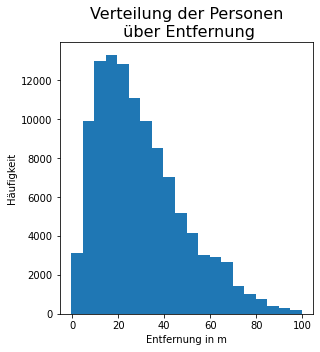

In [28]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121)
ax.hist(poss_df.z, bins=20)

ax.set_title("Verteilung der Personen\n über Entfernung", fontsize=16)
ax.set_xlabel('Entfernung in m')
ax.set_ylabel('Häufigkeit')

In [19]:
poss_df.describe()


,x,y,z
count,110705.000000,110705.000000,110705.000000
mean,336.090666,137.068339,29.838332
std,142.826849,75.288726,18.735376
min,-1032.950684,-231.193008,-0.351333
25%,252.435822,79.503098,15.302668
50%,334.630280,152.722595,26.064001
75%,420.764374,188.183121,40.612003
max,1076.957397,5880.145508,99.793999
